# Training 


In [1]:
import numpy as np
import pandas as pd
import os
import sys  
sys.path.append(".")

# deep learning
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

/opt/anaconda3/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <3224DED3-FCE0-3B10-9D68-9EC019B2AFEC> /opt/anaconda3/lib/python3.7/site-packages/torchvision/image.so
  Expected in:     <7EC12623-0CF1-3739-8CBB-242EFC29E2B3> /opt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Setup

In [2]:
# Check version of Pytorch
print(torch. __version__)

1.13.1


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data


In [4]:
from data import data_cleaning

##  Training data tabular
data_df = data_cleaning.create_feature_df()
#data_df = pd.read_csv("../data/tables/features.csv")
data_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/Users/hanna/Mirror/uni_code/nyu/cog_neuro_final_project/src/data/data_cleaning.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Launch_Year"] = df["Launch_Year"].astype("int")


,Brand_Name,Brand_ID,Model_Name,Model_ID,Bodytype,Launch_Year,Color,Advertiser_ID,Image_ID,Viewpoint,file_path
0,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,1,image_1.jpg,45,Abarth$$124 Spider$$2017$$Blue$$2_1$$1$$image_...
1,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_11.jpg,45,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
2,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_16.jpg,0,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
3,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_18.jpg,270,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
4,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_2.jpg,180,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
...,...,...,...,...,...,...,...,...,...,...,...
271369,Zenos,99,E10,99_1,Convertible,2016,Grey,3,image_7.jpg,90,Zenos$$E10$$2016$$Grey$$99_1$$3$$image_7.jpg
271370,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_0.jpg,225,Zenos$$E10$$2016$$Red$$99_1$$1$$image_0.jpg
271371,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_3.jpg,315,Zenos$$E10$$2016$$Red$$99_1$$1$$image_3.jpg
271372,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_4.jpg,45,Zenos$$E10$$2016$$Red$$99_1$$1$$image_4.jpg


## training data (70%), validation set (10%), test data (20%)

In [5]:
seed = 384
rng = np.random.default_rng(seed)
# TODO: stratify test, train, val by classes (e.g., brand, year, etc.)
# we need to make sure that images of a car model (specified by Model_ID and launch_year) are not distributed over training, validation and test dataset when splitting. 

# subset dataframe by car model (specified by launch_year and model_id) and find unique combinations and then sample accordingly
unique_cars = data_df[["Model_ID", "Launch_Year"]].drop_duplicates()

# draw random indices according to splits from unique cars
rand_nums = rng.uniform(size = len(unique_cars))
msk_train = rand_nums < 0.7 # draws random numbers from uniform distribution, 70%


msk_val_test = ~msk_train # complement

# subset unique cars by indices
msk_val = rand_nums >= 0.9 # 10%

#msk_test = ~msk_val & ~msk_train #  20%
msk_test = (rand_nums > 0.7) & (rand_nums < 0.9)

# test if all datasets only contain unique cars
assert not (np.any(msk_val_test & msk_train))
assert not (np.any(msk_val & msk_test))


# slice unique cars with datamasks 
train_cars_df = unique_cars[msk_train]
test_cars_df = unique_cars[msk_test]
val_cars_df = unique_cars[msk_val]

# check unique cars len is equal to the sum of its sub dfs
assert len(val_cars_df) + len(test_cars_df) + len(train_cars_df) == len(unique_cars)

# complement unique cars per dataset with corresponding rows (launchyear, model id) from features df
# train_df = data.loc[((data['Launch_Year'].isin(train_cars_df['Launch_Year'])) & data['Model_ID'].isin(train_cars_df['Model_ID']))]

# test_df = data.loc[((data['Launch_Year'].isin(test_cars_df['Launch_Year'])) & data['Model_ID'].isin(test_cars_df['Model_ID']))]

# val_df = data.loc[((data['Launch_Year'].isin(val_cars_df['Launch_Year'])) & data['Model_ID'].isin(val_cars_df['Model_ID']))]


#df[df[['a', 'b']].apply(tuple, axis=1).isin([(1,2), (4,3)])]
train_df = data_df[data_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(train_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

val_df = data_df[data_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(val_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

test_df = data_df[data_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(test_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

# check if len of entire data set is equal to sum of test, train and val dataset
assert len(test_df) + len(train_df) + len(val_df) == len(data_df)

In [6]:
train_df["Launch_Year"].unique().size

22

#### Dataset exploration:
- How are car brands distributed over the years in each dataset (val, test, train)?
- How are years distributed over per brand?

In [7]:
# group by year
# count brands

# calculate number of images per year 

def get_images_by_year(data:pd.DataFrame):
    return data.groupby(["Launch_Year"])["file_path"].count()
num_images_by_year_train_df = get_images_by_year(train_df)
num_images_by_year_test_df = get_images_by_year(test_df)
num_images_by_year_val_df = get_images_by_year(val_df)

def plot_dataframes(df:pd.DataFrame,  df_name:str, plot_type:str="bar"):
    df.plot(kind="bar", title=f"Number of Images by Year in {df_name}", xlabel="Years", ylabel="Counts")


### Custom Dataset class

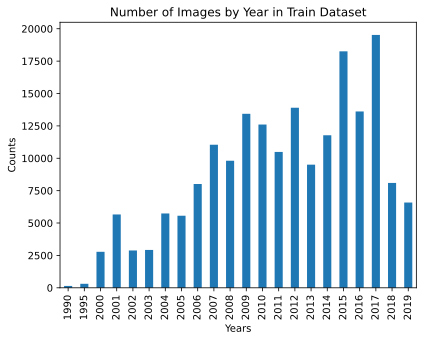

In [8]:
plot_dataframes(num_images_by_year_train_df, df_name="Train Dataset")

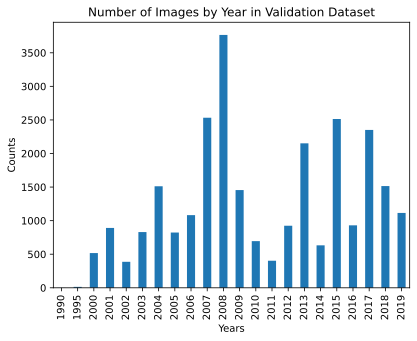

In [9]:
plot_dataframes(num_images_by_year_val_df, df_name="Validation Dataset")

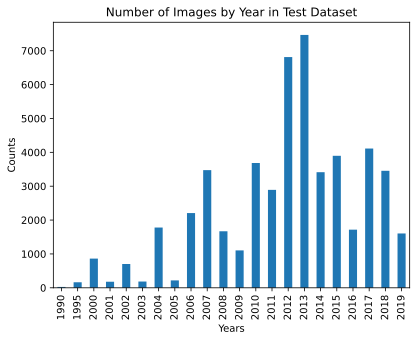

In [10]:
plot_dataframes(num_images_by_year_test_df, df_name="Test Dataset")

In [11]:
# plot stacked number of images by year per dataset 

# combine num_images_by_year_some_dataset dfs to one dataframe
num_images_by_year_all_data = num_images_by_year_train_df.to_frame().join(num_images_by_year_test_df.to_frame(), on="Launch_Year", lsuffix="_train", rsuffix="_test")
num_images_by_year_all_data = num_images_by_year_all_data.join(num_images_by_year_val_df.to_frame(), on="Launch_Year", rsuffix="_val")
num_images_by_year_all_data = num_images_by_year_all_data.rename(columns={"file_path_test":"Num Test Images", "file_path_train":"Num Train Images","file_path":"Num Validation Images"})
num_images_by_year_all_data

,Num Train Images,Num Test Images,Num Validation Images
Launch_Year,,,
1990,144,25,1
1995,307,163,14
2000,2780,862,517
2001,5663,179,891
2002,2884,703,387
2003,2923,185,830
2004,5738,1779,1512
2005,5564,218,823
2006,8013,2207,1082


<AxesSubplot:title={'center':'Number of Images by Launch Year per Dataset'}, xlabel='Launch Year', ylabel='Counts'>

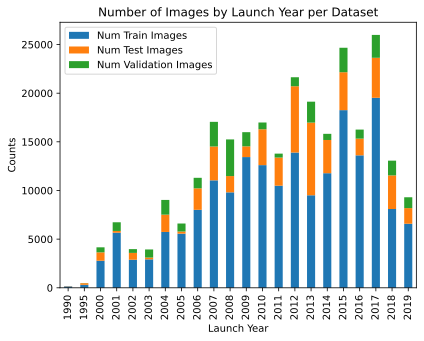

In [12]:
num_images_by_year_all_data.plot.bar(stacked=True, xlabel="Launch Year", ylabel="Counts", title="Number of Images by Launch Year per Dataset")

In [13]:
from typing import Callable
from skimage import io
from data import data_cleaning, year2label_fn, bodytype2label_fn, CarDataset


# set bucket_size for year -> how many years should correspond to one label?
year_bucket_size = 2
min_year = data_df["Launch_Year"].min() # oldest car launch_year in data
max_year = data_df["Launch_Year"].max() # # most recent car launch_year in data
 
car_dataset = CarDataset(train_df,
    lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size), all_cars=True
    )

In [14]:
test_datapoint = car_dataset[10300] # idx 10300 exists in small image dataset

NameError: name 'Viewpoint' is not defined

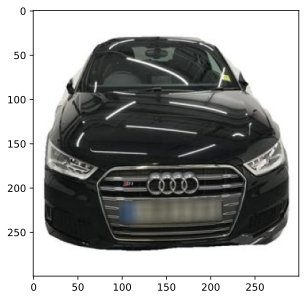

In [ ]:
plt.imshow(test_datapoint[0])

In [ ]:
year2label_fn(2000, min_year=1990, max_year=2010,year_bucket_size=2)

4

In [ ]:
bodytype2label_fn("Car Derived Van")

6

### Data augmentation and transformation:

In [ ]:
# resize images to 224x224 (imageNet size)
# normalize image: 
# mean =[0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] (ImgNet mean and std)
#optional: randomResizedCrop, etc.

# Data agumentation and normalization for training
img_rgb_mean=[0.485, 0.456, 0.406]
img_rgb_std = [0.229, 0.224, 0.225]

data_transforms = {
    "train":transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.ColorJitter(),
            transforms.RandomInvert(),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.1),
            transforms.Normalize(mean=img_rgb_mean,std = img_rgb_std),
        ]
    ),
    "val":transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224,224)),
                        transforms.Normalize(mean=img_rgb_mean,std = img_rgb_std),

        ]
    )
}

def inverse_transform(y:torch.Tensor, mean:list, std:list):
    mean = torch.as_tensor(mean)
    std = torch.as_tensor(std)
    mean = torch.reshape(mean,[3,1,1])
    std = torch.reshape(std,[3,1,1])
    return y*std + mean

In [ ]:
seed_t = 123
torch.manual_seed(seed_t)

# load dataset
# create torch.dataset --> specify transform arguement accordingly

train_set = CarDataset(features=train_df[:1000], transform=data_transforms["train"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size))

test_set = CarDataset(features=test_df[:1000], transform=data_transforms["val"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size))

val_set = CarDataset(features=val_df[:1000], transform=data_transforms["val"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size))


# data loaders for all train, test, val datasets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=True)

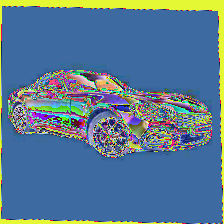

In [ ]:
test_point_transf = train_set[12]
post_transf = torchvision.transforms.functional.to_pil_image(test_point_transf[0])
inv_transf = torchvision.transforms.functional.to_pil_image(inverse_transform(test_point_transf[0], mean=img_rgb_mean, std=img_rgb_std))
post_transf

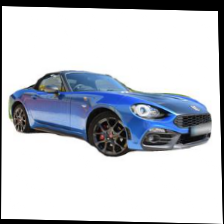

In [ ]:
inv_transf

In [ ]:
test_point_transf[0].shape

torch.Size([3, 224, 224])

In [ ]:
train_df.columns

Index(['Brand_Name', 'Brand_ID', 'Model_Name', 'Model_ID', 'Bodytype',
       'Launch_Year', 'Color', 'Advertiser_ID', 'Image_ID', 'file_path'],
      dtype='object')

In [ ]:
# dataset dic
data_set_dic = dict({"train":train_set, "val":val_set, "test":test_set})

# dataloader dic

dataloader_dic = dict({"train":train_loader, "val":val_loader, "test":test_loader})

#  a dataloader has  the following attributes: 
# image, bodytype, model_id, launch_year, self.bodytype2label_fn(bodytype), self.year2label_fn(year=launch_year, year_bucket_size = self.year_bucket_size)

## Model

In [ ]:
import torchvision.models as models

pretrained_model = models.resnet18(pretrained=True)

# compute number of classes of final layer which depends on year_bucket size and year_range
year_range = max_year - min_year
num_year_classes = 1 +  (year_range // year_bucket_size) # floor division

in_features_final_layer = list(pretrained_model.parameters())[-2].size()[1]# in-features to final layer of resnet18
out_features_final_layer = num_year_classes # the number of classes, year categories


my_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-1]), nn.Flatten()) # add all but final layer from pretrained model

# freeze paramaters of pretrained model:
for param in my_model.parameters():
    param.requires_grad = False

# add custom final layer to resnet18
my_model.add_module(
    "fc",
    nn.Linear(
        in_features = in_features_final_layer,
        out_features = out_features_final_layer
    ),
)


# apply softmax to final layers' outputs
my_model.add_module("sm", nn.Softmax(dim=0))

/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Replace final layer of Resnet18 with a new fully connected layer with number of features equal to the number of output classes and initialize with random weights.


In [ ]:
module_counter = 0
for module in my_model.modules():
   print("MODULE", module_counter, "is:")
   print(module)
   module_counter += 1

MODULE 0 is:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
     

## define loss function, optimizer and learning rate

In [ ]:
learning_rate = 5e-4

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(my_model.fc.parameters(), lr=learning_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Tensorboard visualizations
see: https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/0_experiment_car_year_classifcation')

##  training


In [ ]:
# training loop 

import time

def train_model(model, criterion, optimizer, num_epochs=3, phase="train"):
    acc_per_batch_list = []
    loss_per_batch_list  =[]
    num_batches = 0
    epoch_acc_list = []
    epoch_loss_list = []
    time_list = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # print epoch
        print(f"Epoch {epoch} of {num_epochs -1}")
        print("--" * 10)

        # each epoch has a training and validation phase
        if phase == "train":
            model.train() # set model to training mode

        else:
            model.eval() # set model to evaluation mode

        # for tracking performance
        running_loss = 0.0
        running_corrects = 0.0

        # iterate over data
        ## loop over inputs and labels in dataloaders (in dict form for training/test phase)

        #  a dataloader has  the following attributes: 
        # image, bodytype, model_id, launch_year, self.bodytype2label_fn(bodytype), self.year2label_fn(year=launch_year, year_bucket_size = self.year_bucket_size)

        ## inputs and labels to device
        for inputs, _, _, _, _,year_labels in dataloader_dic[phase]:

            print(inputs.shape)
 
            inputs = inputs.to(device)
            year_labels = year_labels.to(device)
    

            ## zero the parameters of the gradient
            optimizer.zero_grad()

            # forward pass
            # track history only if in train mode
            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, predictions = torch.max(outputs,1) # dim = 1
                loss = criterion(outputs, year_labels)
                # backward + optimize only when in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics:
            num_corrects = torch.sum(predictions == year_labels.data).item()
            running_corrects += num_corrects
            num_batches += 1
            acc_per_batch = num_corrects / inputs.size(0)
            loss_per_batch = loss.item()
            running_loss  += loss_per_batch
            loss_per_batch_list.append(loss_per_batch)
            acc_per_batch_list.append(acc_per_batch)


        epoch_loss = (running_loss / len(data_set_dic[phase]))
        epoch_acc = running_corrects / len(data_set_dic[phase]) #  .double() is equivalent to self.to(torch.float64)
        epoch_acc_list.append(epoch_acc)
        epoch_loss_list.append(epoch_loss)
        print(f"{phase}:, Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

        # record training time
        time_list.append(time.time() - start_time)
        print(f"Time up to epoch {epoch}: {time_list[epoch]}")
    
    return list(range(num_batches)), loss_per_batch_list, acc_per_batch_list, list(range(num_epochs)), epoch_loss_list, epoch_acc_list, time_list

    

In [ ]:
train_num_batches_lst, train_loss_per_batch_lst, train_acc_per_batch_lst, train_num_epochs_lst, train_epoch_loss_lst, train_epoch_acc_lst, train_time_list = train_model(my_model, criterion=criterion, optimizer=optimizer, phase="train")

Epoch 0 of 2
--------------------
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([8, 3, 224, 224])
train:,

##  evaluation

In [ ]:
val_num_batches_lst, val_loss_per_batch_lst, val_acc_per_batch_lst, val_num_epochs_lst, val_epoch_loss_lst, val_epoch_acc_lst, val_time_list = train_model(my_model, criterion=criterion, optimizer=optimizer, phase="val")

Epoch 0 of 2
--------------------
torch.Size([32, 3, 224, 224])
val:, Loss: 0.0846 Accuracy: 0.0938
Time up to epoch 0: 2.421281099319458
Epoch 1 of 2
--------------------
torch.Size([32, 3, 224, 224])
val:, Loss: 0.0846 Accuracy: 0.0938
Time up to epoch 1: 2.084684133529663
Epoch 2 of 2
--------------------
torch.Size([32, 3, 224, 224])
val:, Loss: 0.0846 Accuracy: 0.0938
Time up to epoch 2: 2.0791869163513184


In [ ]:
# plotting function for accuracy and loss on training and validation data set

def plot(train_num_batches_lst, train_loss_per_batch_lst, train_acc_per_batch_lst, train_num_epochs_lst, train_epoch_loss_lst, train_epoch_acc_lst, time_list, val_epoch_loss_lst, val_epoch_acc_lst):

  fig, axes = plt.subplots(nrows=2, ncols=3, sharey="row")

  # batch
  axes[0,0].plot(train_num_batches_lst, train_loss_per_batch_lst, color="C0", label="train")
  axes[0,0].plot(val_num_batches_lst, val_loss_per_batch_lst, color="C1", label="validation")

  axes[1,0].plot(train_num_batches_lst, train_acc_per_batch_lst, color="C0", label="train")
  #axes[1,0].plot(val_num_batches_lst, val_accuracy_lst, color="C1", label="validation")

  # epoch
  axes[0,1].plot(train_num_epochs_lst, train_epoch_loss_lst, color="C0", label="train")
  axes[0,1].plot(train_num_epochs_lst, val_epoch_loss_lst, color="C1", label="validation")

  axes[1,1].plot(num_epochs_lst, train_epoch_acc_lst, color="C0", label="train")
  axes[1,1].plot(num_epochs_lst, val_epoch_acc_lst, color="C1", label="validation")

  # time
  axes[0,2].plot(time_list, train_epoch_loss_lst, color="C0", label="train")
  axes[0,2].plot(time_list, val_epoch_loss_lst, color="C1", label="validation")

  axes[1,2].plot(time_list, train_epoch_acc_lst, color="C0", label="train")
  axes[1,2].plot(time_list, val_epoch_acc_lst, color="C1", label="validation")

  axes[0,0].set(ylabel="CE-Loss")
  axes[1,0].set(xlabel="batches", ylabel="accuracy")
  axes[1,1].set(xlabel="epoch")
  axes[1,2].set(xlabel="time")
  axes[0,0].legend()
  axes[0,1].legend()
  axes[0,2].legend()
  plt.show()


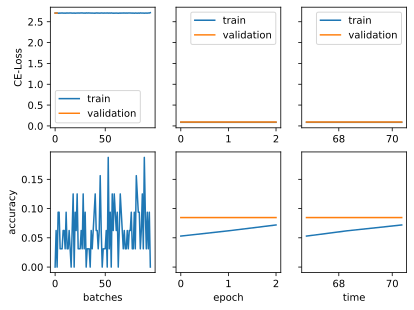

In [ ]:
plot(
    train_num_batches_lst=train_num_batches_lst,
    train_loss_per_batch_lst=train_loss_per_batch_lst, 
    train_acc_per_batch_lst=train_acc_per_batch_lst, 
    train_epoch_loss_lst=train_epoch_loss_lst, 
    train_epoch_acc_lst=train_epoch_acc_lst, 
    train_num_epochs_lst=train_num_epochs_lst, 
    time_list = train_time_list,
    val_epoch_acc_lst=val_epoch_loss_lst,
    val_epoch_loss_lst=val_epoch_acc_lst
    )

## Modernity 
Design Modernity Score:
- Assumption:  
    - the newer the car (wrt procuction year), the more modern it is
- Calculation:
    - weighted sum of the production year category labels:
        weight labels (0, 1, 2, 3, etc.) by respective predicted probabilitiy 

In [ ]:
def modernity_score_fn(prob_per_label: torch.Tensor):
    """gets model output from prediction of model and computes modernity score"""

    # modernity score = weighted sum of model_outputs times year_label 
    # year labels start with 0, so make sure to +1 each label
    year_labels = torch.arange(num_year_classes) + 1

    return torch.sum(year_labels * prob_per_label, dim=1)

In [ ]:
# select test images
img_tens, body_type, _, launch_year, bodytype_label, year_label = next(iter(dataloader_dic["test"]))

In [ ]:
predicted_probs = my_model(img_tens)
predicted_probs.shape

torch.Size([1000, 15])

In [ ]:
modernity_score_fn(predicted_probs)

tensor([3.8798, 4.4640, 3.9712, 3.5086, 3.1998, 3.0303, 2.9671, 3.8330, 3.7437,
        3.4360, 4.0611, 3.4244, 3.9875, 4.2207, 3.6809, 3.7705, 3.8708, 3.7502,
        3.4922, 3.6501, 3.9807, 3.9199, 3.2687, 2.9812, 4.5181, 3.9751, 3.8753,
        4.0800, 4.0793, 4.0263, 3.1796, 4.1738], grad_fn=<SumBackward1>)

In [ ]:
def imshow(img):
    img = inverse_transform(img,mean=img_rgb_mean, std=img_rgb_std)

    img = img.to("cpu")
    img = torchvision.utils.make_grid(img, nrow=4)
    npimg = img.numpy()
    # rotate image by transposing dimensions accordingly
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

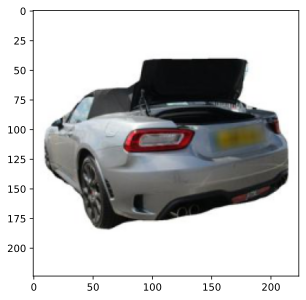

In [ ]:
imshow(train_set[21][0])


In [ ]:
my_model(img_tens).shape[-1]

15

In [ ]:
# get random images per year

def get_random_img_per_year(year_of_interest:int, number:int=4, images=img_tens, years=launch_year):
    mask = year_of_interest == years 
    print(mask)
    if mask.sum() == 0:
        raise ValueError(f"Year {year_of_interest} does not exist in current batch.")
    images_per_year = images[mask]
    random_idx  = torch.randperm(sum(mask))[:number]
    return images_per_year[random_idx], years[mask][random_idx], random_idx

In [ ]:
img_tens.shape

torch.Size([1000, 3, 224, 224])

tensor([ True, False, False, False, False, False, False, False, False,  True,
        False,  True, False,  True, False, False, False, False, False,  True,
         True,  True,  True, False, False, False, False, False, False, False,
         True, False,  True, False, False, False, False, False, False, False,
         True, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False,  True, False,  True, False, False,
        False, False,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False,  True, False, False,  True, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True, False, False, False, False, False, 

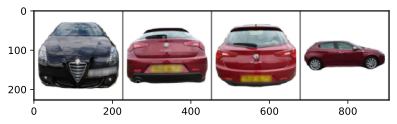

The modernity scores in year 2010 are: ['0.13', '0.11', '0.12', '0.11']
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,

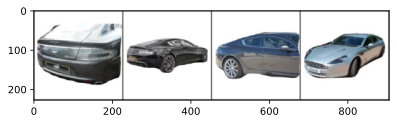

The modernity scores in year 2011 are: ['0.12', '0.14', '0.13', '0.10']
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,

ValueError: Year 2012 does not exist in current batch.

In [ ]:
# print 4 random images and respective modernity score for years of interest (2000, 2006, 2010, 2014, 2017)

years_of_interest = [2010,2011,2012]
#years_of_interest = [2015]

for i, year in enumerate(years_of_interest):
    img_t, year_t, random_idx = get_random_img_per_year(year)
    print(f"YEAR: {years_of_interest[i]}")
    modernity_score = modernity_score_fn(predicted_probs[random_idx]).tolist()
    modernity_score = ["%.2f" % elem for elem in modernity_score]
    imshow(img_t)
    print(
        f"The modernity scores in year {year} are: {modernity_score}"
    )
